# We will predict India's real GDP using time-series tools

In [ ]:
!pip install pmdarima

In [ ]:
%load_ext rpy2.ipython

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

In [ ]:
# loading the data

gdp = pd.read_csv("https://raw.githubusercontent.com/theanishk/Projects/main/Forecasting%20India's%20GDP/RealGDP.csv", index_col='date')
gdp.index = pd.DatetimeIndex(gdp.index)

In [ ]:
gdp.head()

,gdp
date,
01/04/04,11733600.0
01/07/04,11859400.0
01/10/04,13303400.0
01/01/05,13824500.0
01/04/05,12815900.0


In [ ]:
# converting the GDP in million USD

gdp = gdp/1000000

In [ ]:
# plotting the GDP's graph

fig = px.line(gdp, line_shape='linear', markers=True,
              labels={
                     "variable": "Legend"
                 })

fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text=r'$GDP_r \text{ (in million USD)}$')

fig.update_layout(
    title=dict(text="Real GDP of India", font=dict(size=23)),
    legend_title_font_color="red"
)
fig.show();

CoVID struck India in early 2020, which can be seen in data as 2020-Q2 (2020-04-01) GDP suffered a lot. This is a intervention in the series. So to build the model we will only use data before intervention i.e. preintervention.

In [ ]:
# selecting pre-intervention data i.e. before 2020

pre_covid_gdp = gdp[:'01/01/20']

From graph we can see the series to be non-stationary but we can also using formal test of Augmented Dickey-Fuller.

For Augmented Dickey-Fuller test-

$ {H_0}: \text{Series is non-stationary i.e.}\ \rho \ge 1 $

$ {H_1}: \text{Series is stationary i.e.}\ \rho < 1 $


In [ ]:
dftest = adfuller(pre_covid_gdp.gdp, autolag='BIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  0.8320564331057378
2. P-Value :  0.9921363872455462
3. Num Of Lags :  4
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 59
5. Critical Values :
	 1% :  -3.5463945337644063
	 5% :  -2.911939409384601
	 10% :  -2.5936515282964665


Since, p-value > 0.05, for 95% confidence level. Hence, we can't reject the null hypothesis so the series is non-stationary.

To achieve stationary process we can do the first difference-

$$ \nabla Y_t = Y_t - Y_{t-1} $$
where Y is GDP

In [ ]:
first_diff = pre_covid_gdp.gdp.diff(periods = 1).iloc[1:]

In [ ]:
dftest = adfuller(first_diff, autolag='BIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -2.7331288258328437
2. P-Value :  0.06847887326201997
3. Num Of Lags :  3
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 59
5. Critical Values :
	 1% :  -3.5463945337644063
	 5% :  -2.911939409384601
	 10% :  -2.5936515282964665


Here the p-value is 0.068 and it is very close to 0.05. So we can say after first difference the series becomes stationary. (This will be true for 90% confidence level)

Now, we will use ACF and PACF to get the further knowledge

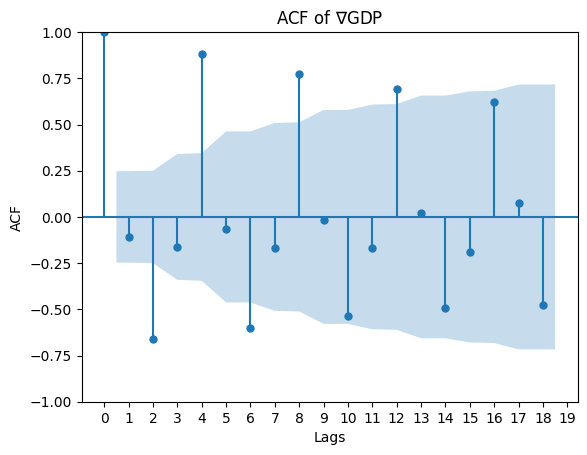

In [ ]:
plot_acf(first_diff)
plt.title('ACF of $\u2207$GDP')
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.xticks(np.arange(0, 20, 1))
plt.show();

<Figure size 1000x200 with 0 Axes>

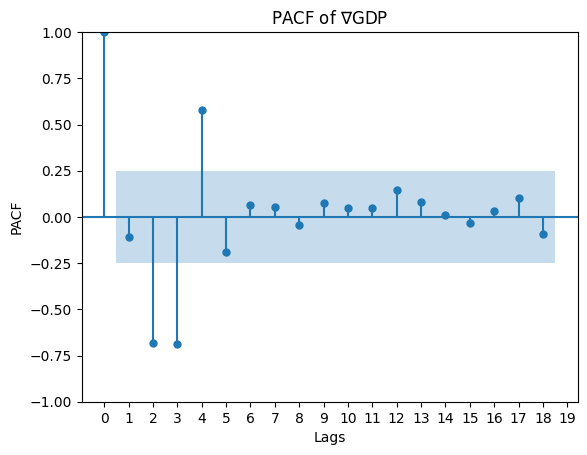

In [ ]:
plot_pacf(first_diff, method='ywm')        # we are using Yule-Walker method
plt.title('PACF of $\u2207$GDP')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.xticks(np.arange(0, 20, 1))
plt.show();

There is always high correlation for ever 4 lags (1 year), i.e. the has seasonality.

So we will remove the seasonality,

$$\nabla_4 \nabla Y_t = \nabla Y_t - \nabla Y_{t-4}$$
$$\hspace{1mm} = Y_t - Y_{t-1} - Y_{t-4} + Y_{t-5}$$

In [ ]:
first_fourth_diff = gdp.gdp.diff(periods = 1).diff(periods = 4).iloc[5:]

ACF and PACF after making stationarity and removing seasonality from series

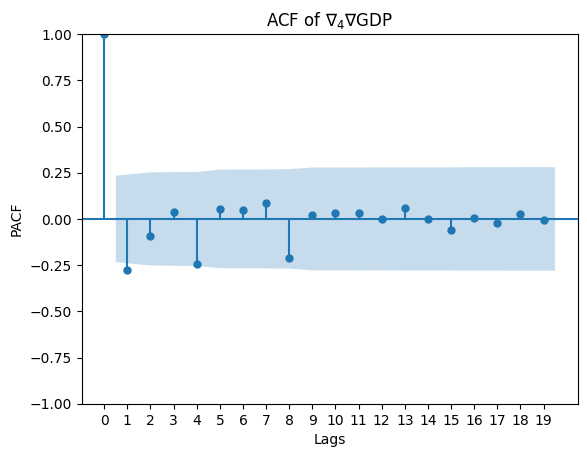

In [ ]:
plot_acf(first_fourth_diff)
plt.title('ACF of $\u2207_4 \u2207$GDP')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.xticks(np.arange(0, 20, 1))
plt.show();

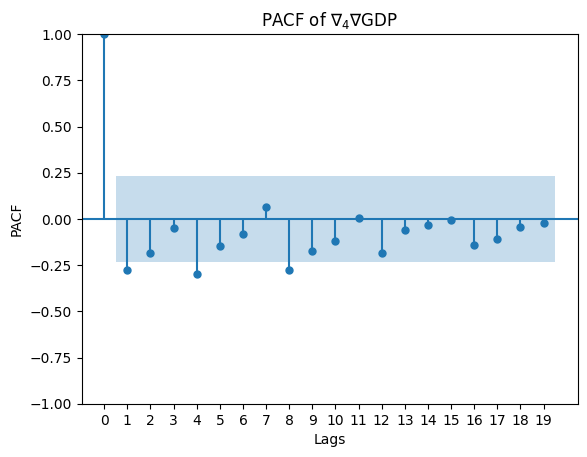

In [ ]:
plot_pacf(first_fourth_diff, method='ywm')
plt.title('PACF of $\u2207_4 \u2207$GDP')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.xticks(np.arange(0, 20, 1))
plt.show();

Based on ACF and PACF plot of the new series after first and fourth differencing, we can see very low statistically correlation.

In [ ]:
model = pm.auto_arima(pre_covid_gdp, seasonal=True, m=4, trace=True);
print("Selected ARIMA Order:", model.order)
print("Selected Seasonal Order:", model.seasonal_order)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[4]             : AIC=59.433, Time=0.62 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=55.347, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=57.963, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=57.463, Time=0.15 sec
 ARIMA(0,1,0)(1,1,0)[4]             : AIC=55.965, Time=0.06 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=55.481, Time=0.07 sec
 ARIMA(0,1,0)(1,1,1)[4]             : AIC=56.240, Time=0.13 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=57.347, Time=0.07 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=57.347, Time=0.06 sec
 ARIMA(1,1,1)(0,1,0)[4]             : AIC=58.001, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[4] intercept   : AIC=57.347, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,1,0)[4]          
Total fit time: 1.558 seconds
Selected ARIMA Order: (0, 1, 0)
Selected Seasonal Order: (0, 1, 0, 4)


Based on preintervention data we can say the model is $ARIMA(0,1,0)(0,1,0)_4$

In [ ]:
print(model.fit(list(gdp.gdp)).summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                   75
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 4)   Log Likelihood                -133.618
Date:                           Sun, 03 Sep 2023   AIC                            269.236
Time:                                   13:25:03   BIC                            271.484
Sample:                                        0   HQIC                           270.129
                                            - 75                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         2.6638      0.146     18.293      0.000       2.378       2.949
Ljung-Box (L1) (Q):                   5.66 

In [ ]:
predicted_values, confidence_intervals = model.predict(n_periods=11, return_conf_int=True)
# forecast_index = pd.date_range(start='01/01/20', periods=len(predicted_values), freq='Q')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



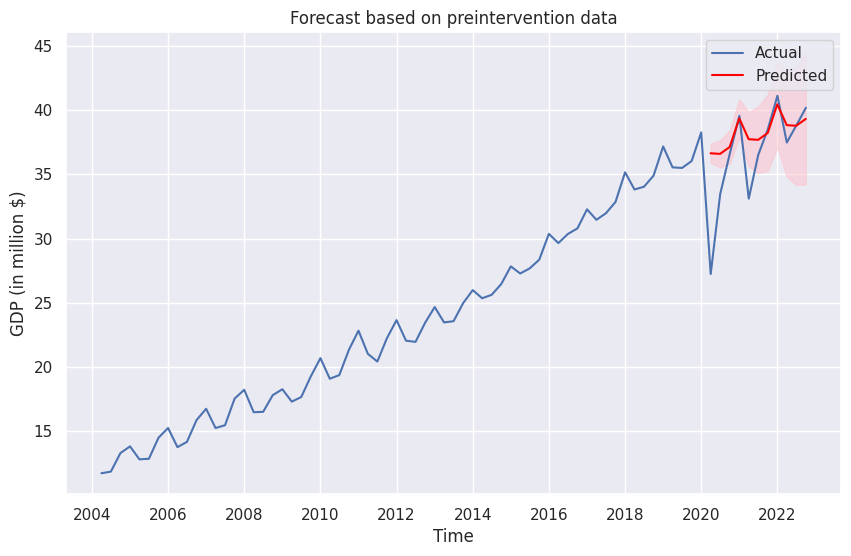

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(gdp, label='Actual')
plt.plot(forecast_index, predicted_values, label='Predicted', color='red')
plt.fill_between(forecast_index, confidence_intervals[:, 0], confidence_intervals[:, 1], color='pink', alpha=0.5)
plt.legend()
plt.xlabel('Time')
plt.ylabel('GDP (in million $)')
plt.title('Forecast based on preintervention data')
plt.show()

**Forecating and Finding best model**

In [ ]:
y = list(gdp.gdp)

Model 1- Without any intervention

In [ ]:
# Define the ARIMA model with seasonality (0, 1, 0)(0, 1, 0)[4]
order = (0, 1, 0)
seasonal_order = (0, 1, 0, 4)

model1 = SARIMAX(y, order=order, seasonal_order=seasonal_order)
results1 = model1.fit()

# Print the model summary
print(results1.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                   75
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 4)   Log Likelihood                -133.618
Date:                           Sun, 03 Sep 2023   AIC                            269.236
Time:                                   13:50:46   BIC                            271.484
Sample:                                        0   HQIC                           270.129
                                            - 75                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         2.6638      0.146     18.293      0.000       2.378       2.949
Ljung-Box (L1) (Q):                   5.66 

In [ ]:
n_forecast = 8
forecast = results1.get_forecast(steps=n_forecast)

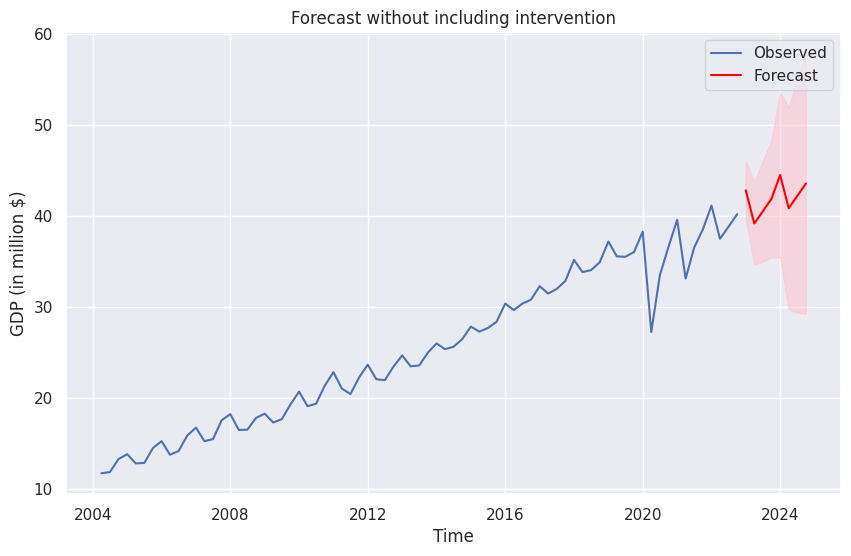

In [ ]:
# Extract the forecasted values and confidence intervals
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int(alpha=0.05)

last_date = gdp.index[-1]
forecast_dates = pd.date_range(start=last_date, periods=n_forecast, freq='Q')

# Plot the forecasted values
plt.figure(figsize=(10, 6))
plt.plot(gdp.index, y, label='Observed')
plt.plot(forecast_dates, forecast_values, label='Forecast', color='red')

# Plot the confidence intervals
plt.fill_between(forecast_dates, confidence_intervals[:, 0], confidence_intervals[:, 1], color='pink', alpha=0.5)

plt.title('Forecast without including intervention')
plt.xlabel('Time')
plt.ylabel('GDP (in million $)')
plt.legend()
plt.show()


In [ ]:
forecast_values

array([42.8017, 39.1572, 40.488 , 41.8639, 44.4798, 40.8353, 42.1661,
       43.542 ])

Model 2- With innovative outlier at 65, 66 and 69

In [ ]:
# Create an exogenous variable for the innovative outliers
outlier_data = np.zeros(len(y))
outlier_indices = [64, 65, 68]
outlier_data[outlier_indices] = 1

# Create a DataFrame with the exogenous variable
exog_data = pd.DataFrame({'Outliers': outlier_data})

# Create and fit the ARIMA model with the seasonal order and exogenous variable
model2 = SARIMAX(y, order=order, seasonal_order=seasonal_order, exog=exog_data)
results2 = model2.fit()

# Print the model summary
print(results2.summary())


                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                   75
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 4)   Log Likelihood                -125.511
Date:                           Sun, 03 Sep 2023   AIC                            255.021
Time:                                   13:53:02   BIC                            259.518
Sample:                                        0   HQIC                           256.807
                                            - 75                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Outliers      -2.5349      0.249    -10.188      0.000      -3.023      -2.047
sigma2         2.1131      0.135     15.644

In [ ]:
exog_data

,Outliers
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
70,0.0
71,0.0
72,0.0
73,0.0


In [ ]:
n_forecast = 8
forecast = results2.get_forecast(steps=n_forecast, exog=exog_data[-8:])

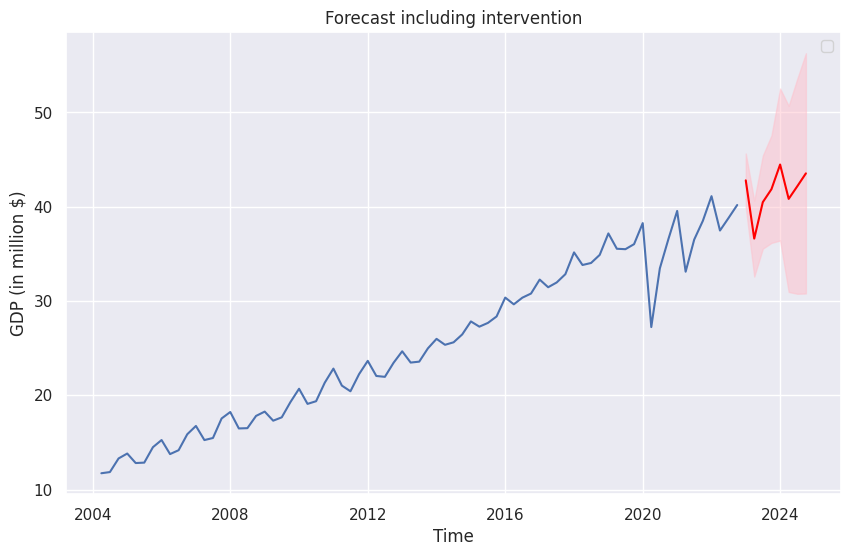

In [ ]:
# Extract the forecasted values and confidence intervals
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

last_date = gdp.index[-1]
forecast_dates = pd.date_range(start=last_date, periods=n_forecast, freq='Q')

# Plot the forecasted values
plt.figure(figsize=(10, 6))
plt.plot(gdp.index, y, label='Observed')
plt.plot(forecast_dates, forecast_values, label='Forecast', color='red')

# Plot the confidence intervals
plt.fill_between(forecast_dates, confidence_intervals['lower y'], confidence_intervals['upper y'], color='pink', alpha=0.5)

plt.title('Forecast including intervention')
plt.xlabel('Time')
plt.ylabel('GDP (in million $)')
plt.legend('')
plt.show()


In [ ]:
forecast_values

75    42.801700
76    36.622265
77    40.488000
78    41.863900
79    44.479800
80    40.835300
81    42.166100
82    43.542000
Name: predicted_mean, dtype: float64

Now the model is-
$$\nabla_4 \nabla Y_t = \epsilon_t$$
$$\hspace{1mm} \implies Y_t = Y_{t-1} + Y_{t-4} - Y_{t-5} + \epsilon_t$$